# 8 - Depth-band plot

Loads depth-frequency-time data and then plots integrated depth-band power for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import numpy as np
for i in range(2):
    %matplotlib notebook

In [38]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018
ds_in = xr.open_dataset(f'../Data/data/spectro/spectro_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectro/spectro_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [39]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                     # input end date in YYYY,MM,DD
depth = ds[0].depth.values
d = len(depth)
f = ds[0].specf.values

## Depth-band spectra

In [40]:
# process to find nearby indices for desired freq band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf)    # input array to process 

f_name = 'Diurnal'
if f_name == 'Diurnal':
    f_freq = 1.15e-5        # desired frequency constituent
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")

f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
up_f_idx = f_idx + 1
low_f_idx = f_idx - 1 

print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

Desired frequency band: Diurnal at 1.15e-05 Hz
---
Index at upper freq cutoff: 12
Value at upper freq cutoff: 1.3007812500000002e-05 Hz
---
Index at lower freq cutoff: 10
Value at lower freq cutoff: 1.083984375e-05 Hz
---
Length of new freq array:  3
Upper limit at 1.3007812500000002e-05 Hz
Lower limit at 1.083984375e-05 Hz


In [41]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

<IPython.core.display.Javascript object>


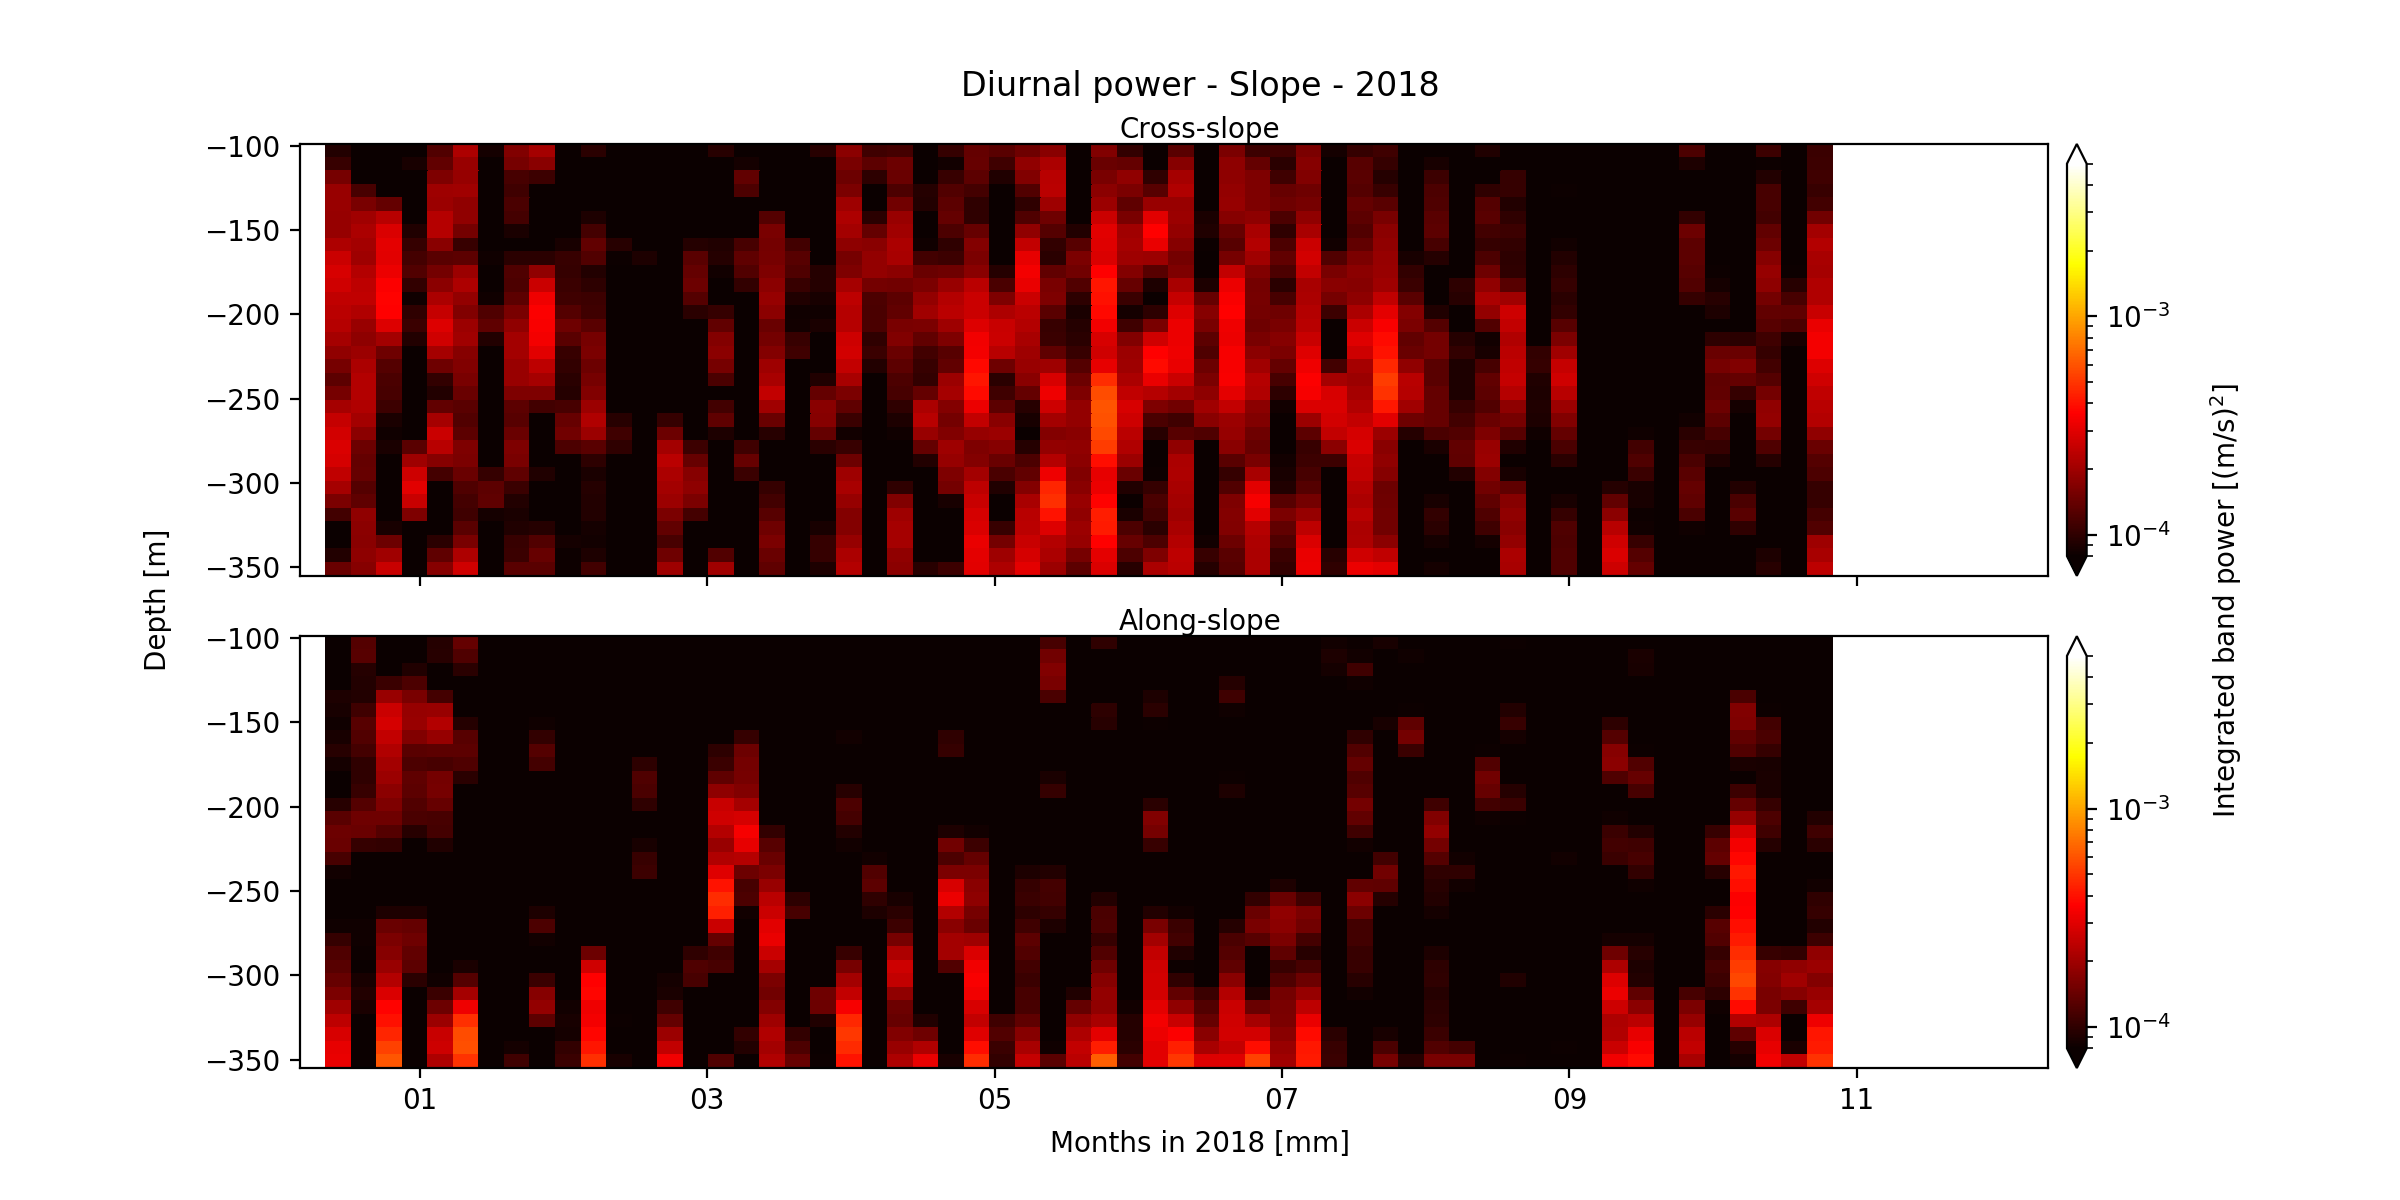

In [42]:
# plot frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(12,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.14)

fig.text(0.5, 0.92, f'{f_name} power - {adcp} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.92, 0.5, 'Integrated band power [(m/s)$^2$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, f'Months in {t_stamp} [mm]', ha='center')
fig.text(0.5, 0.885, 'Cross-slope', ha='center', fontsize=10)
fig.text(0.5, 0.475, 'Along-slope', ha='center', fontsize=10)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 8e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = vmin
        vmax = vmax

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect, -depth, u_power[i][:,:], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im1 = ax1.pcolormesh(ds[i].spect, -depth, v_power[i][:,:], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=20, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=20, extend='both')  

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_{adcp}_{t_stamp}.pdf',format='pdf')